# Первое задание.
## Работу выполнил: Шурыгин Антон, Б01 - 909.

### Генерация индивидуального варианта.


In [ ]:
import numpy as np
from zlib import crc32

types = ['regression', 'classification']
datasets = {'regression': [{'name': 'Servo Data Set',
                            'url': 'https://archive.ics.uci.edu/ml/datasets/Servo'}, 
                           {'name': 'Forest Fires Data Set',
                            'url': 'https://archive.ics.uci.edu/ml/datasets/Forest+Fires'},
                           {'name': 'Boston Housing Data Set',
                            'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston'}, 
                           {'name': 'Diabetes Data Set',
                            'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes'}],
            'classification': [{'name': 'Spambase Data Set',
                                'url': 'https://archive.ics.uci.edu/ml/datasets/Spambase'}, 
                               {'name': 'Wine Data Set',
                                'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine'}, 
                               {'name': 'Breast Cancer Data Set',
                                'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer'}, 
                               {'name': 'MNIST',
                                'url': 'http://yann.lecun.com/exdb/mnist/'}]}
methods = {'regression': ['Линейная регрессия', 
                          'Перцептрон', 
                          'Надарая-Ватсона',
                          'SVR'],
           'classification': ['Логистическая регрессия', 
                              'Перцептрон', 
                              'k-ближайших соседей',
                              'Метод потенциальных функций',
                              'Метод Парзеновского окна', 
                              'SVM']}
task = dict()
task['mail'] = input(prompt='Enter your mail: ')
task['id'] = crc32(task['mail'].encode('utf-8'))
np.random.seed(task['id'])
task['type'] = np.random.choice(types)
task['dataset'] = np.random.choice(datasets[task['type']])
task['method'] = np.random.choice(
    methods[task['type']], size=3, replace=False).tolist()


task

Enter your mail: shurygin.aa@phystech.edu


{'mail': 'shurygin.aa@phystech.edu',
 'id': 2566581683,
 'type': 'regression',
 'dataset': {'name': 'Forest Fires Data Set',
  'url': 'https://archive.ics.uci.edu/ml/datasets/Forest+Fires'},
 'method': ['Надарая-Ватсона', 'Линейная регрессия', 'Перцептрон']}

### Подключаем небоходимые модули

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# pretty data table dump
from google.colab import data_table
data_table.enable_dataframe_formatter()

# pretty plot view
from google.colab import widgets

from sklearn.metrics import mean_squared_error, r2_score

### Определим сущность ***DataWrapper*** - класс владеющий и управляющий загруженным датасетом.

Краткая документация всех методов приведена над соответствующим методом.

In [279]:
class DataWrapper:
  def __init__(self, path : str = str(), feature_vars : list = list(), target_vars : list = list()):
    #
    self.feature_vars = feature_vars
    self.target_vars = target_vars
    self.all_vars = feature_vars + target_vars
    #
    self.dataset = pd.read_csv(path, names=self.all_vars, header=0)
    print(f'Размер выборки составляет l={len(self.dataset)} объектов.')
    #
    self.feature_test, self.feature_train = None, None 
    self.target_test, self.target_train = None, None
    #
  
  # NOTE: simple plot builder
  def get_plot(self, x, y, title : str = str(), xlab : str = str(), ylab : str = str()):
    plt.figure(figsize=(16,10))
    plt.scatter(x, y, c = 'r')

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    #
  
  # NOTE: pretty seaborn hist dump
  def get_pretty_hist(self, name : str):
    plt.figure(figsize=(16,10))
    sns.countplot(self.dataset[name])
    plt.title(name)
      #
  
  # NOTE: simple hist dump
  def get_hist(self, data, title):
    plt.figure(figsize=(16,10))
    plt.hist(data)
    plt.title(title)
      #
  
  # NOTE: function to dump histogram for every var from vars list
  # in special colab tabs 
  def get_hist_in_tabs(self, dataset, vars):
    #
    tab_bar = widgets.TabBar(vars)
    for var_it in vars:
      with tab_bar.output_to(var_it):
        self.get_hist(dataset[var_it], var_it)
          #
  
  # NOTE: function to build plot for every var from vars list
  # in special colab tabs
  def get_plot_in_tabs(self, x_data, y_data, vars : list = list()):
    tab_bar = widgets.TabBar(vars)

    for var_it, column in zip(vars, x_data.columns):
        with tab_bar.output_to(var_it):
          self.get_plot(x=x_data[column], y=y_data, title=f"Plot {var_it}, burned area", xlab=var_it, ylab="area")
          #
  
  # NOTE: correlation heatmap builder & dump
  def get_corr(self, data : pd.DataFrame):
    # train_joined = features_train.join(target_train)
    corr_mat = data.corr()

    plt.figure(figsize=(30, 15))
    sns.heatmap(corr_mat, cmap='coolwarm', annot=True)
    plt.show()
    #
  
  # NOTE: custom dataset splitter
  def split_dataset(self, dataset : pd.DataFrame, target_var, testsize : float, random_st : int):
    feautres = dataset.drop(target_var, axis = 1)
    target = dataset[target_var].values.reshape(-1, 1)

    self.features_train, self.features_test,\
                         self.target_train, self.target_test = train_test_split(feautres, target,\
                                                                                test_size = testsize, random_state=random_st)
    #
  
  # NOTE: custom feature data scaller
  def scale_features(self):
    sc_feature = StandardScaler()
    #
    self.features_test = sc_feature.fit_transform(self.features_test)
    self.features_train = sc_feature.transform(self.features_train)
    #
  #
  def scale_target(self):
    sc_target = StandardScaler()
    #
    self.target_test = sc_target.fit_transform(self.target_test)
    self.target_train = sc_target.transform(self.target_train)

    #
  #
  # NOTE: cast feature & target data to pandas DataFrame
  def data2dataframe(self):
    self.features_test = pd.DataFrame(self.features_test, columns = self.feature_vars)
    self.features_train = pd.DataFrame(self.features_train, columns = self.feature_vars)
    self.target_test = pd.DataFrame(self.target_test, columns = self.target_vars)
    self.target_train = pd.DataFrame(self.target_train, columns = self.target_vars)
    #
  
  # NOTE: cast feature & target data to numpy array
  def data2numpyarr(self):
    self.features_train = self.features_train.to_numpy()
    self.features_test = self.features_test.to_numpy()  
    self.target_train = self.target_train.to_numpy()
    self.target_test = self.target_test.to_numpy()
    #
    # NOTE: target vector reshaping from (n, 1) to (n,)
    self.target_train = self.target_train.reshape((self.target_train.shape[0], ))
    self.target_test = self.target_test.reshape((self.target_test.shape[0], ))

  def upd_features(self, new_features):
    self.features_train = self.features_train.loc[:, new_features]
    self.features_test = self.features_test.loc[: , new_features]
    #
  #

  # NOTE: function to run any model
  def run_model(self, model, dump = False):
    pred_train = model.predict(self.features_train)
    #
    r2 = r2_score(self.target_train, pred_train)
    rmse = mean_squared_error(self.target_train, pred_train, squared = False)
    #
    if dump:
      print(f"For the train set the r2 is: {r2}\nThe RMSE is: {rmse}")

    pred_test = model.predict(self.features_test)
    r2 = r2_score(self.target_test, pred_test)
    rmse = mean_squared_error(self.target_test, pred_test, squared = False)
    #
    if dump:
      print(f"For the train set the r2 is: {r2}\nThe RMSE is: {rmse}")

    return pred_test, r2
    #
  #
  def plot_compare(self, target_test_predict):
    plt.figure(figsize=[40,15])
    plt.plot(self.target_test, color = "red", label = 'True value')
    plt.plot(target_test_predict, label = 'Predicted value')
    plt.title('Evaluation result')
    #
    plt.grid()
    plt.legend()

    plt.show()
    #
  #
  def evaluation(self, target_test_predict):
    #
    fig, ax = plt.subplots(figsize=(10,6))
    ax.scatter(self.target_test, target_test_predict)
    ax.plot(ax.get_xlim(), ax.get_ylim(), color ='red')
    #
    plt.xlabel('True value')
    plt.ylabel('Predicted values')
    plt.title('Evaluation result')
    plt.show()
    #
  #


# NOTE: function to check variation inflation factor
def check_vif(features_train):
  vif = pd.Series([variance_inflation_factor(features_train.values, i) 
                  for i in range(features_train.shape[1])], 
                index = features_train.columns)
  print(vif)

  # NOTE: padnas DataFrame concat
def join_data(lhs : pd.DataFrame, rhs : pd.DataFrame):
  return lhs.join(rhs)

### Загрузим и выведем полученные данные.

In [280]:
data_https = "https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv"
feature_var = ['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
target_var = ['area']

wrapp = DataWrapper(data_https, feature_var, target_var)
wrapp.dataset

Размер выборки составляет l=517 объектов.


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


## 1. Проводим анализ загруженного датасета.


### В данной задачи исходное множество описывается 12 входными переменными:

1. X - пространственная координата по оси x на карте парка Монтесиньо

2. Y - пространственная координата по оси Y на карте парка Монтесиньо

3. месяц - месяц года: от "янв" до "декабрь"

4. день - день недели: от "пн" до "вс"

5. FFMC — индекс FFMC из системы FWI

6. DMC - индекс DMC по системе FWI

7. DC - индекс DC по системе FWI

8. ISI - индекс ISI из системы FWI

9. temp - температура в градусах Цельсия

10. RH - относительная влажность в %

11. ветер - скорость ветра в км/ч

12. дождь - дождь снаружи в мм/м2

### И одной выходной переменной:

1. area - сгоревшая площадь леса (в га)

### Анализируем полученные данные:

- Расссмотим гистограммы полученных данных: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

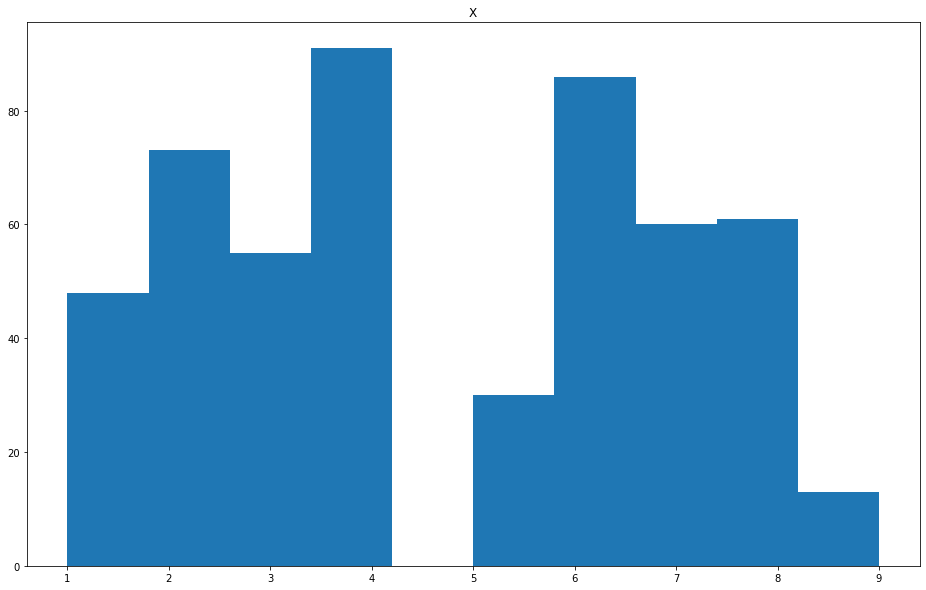

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

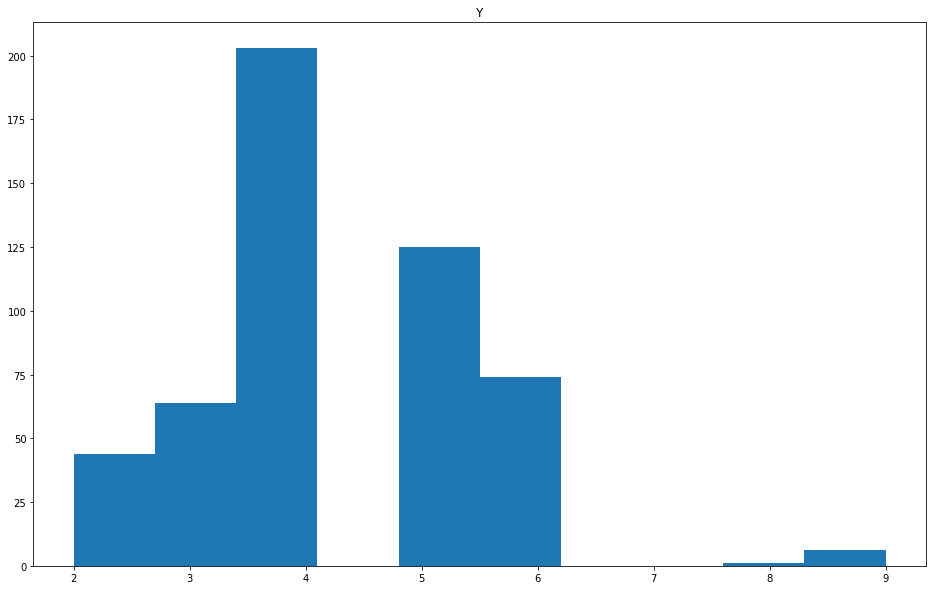

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

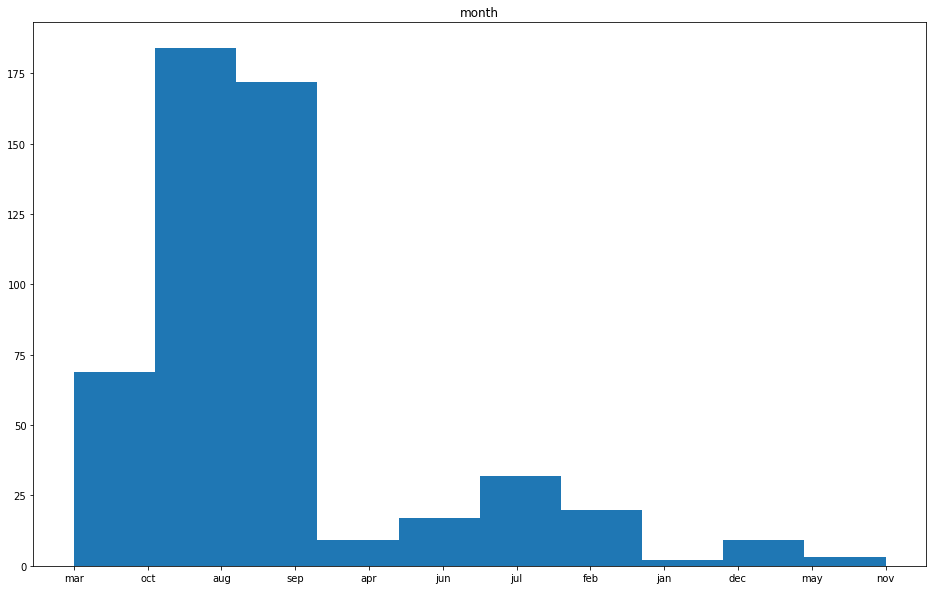

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

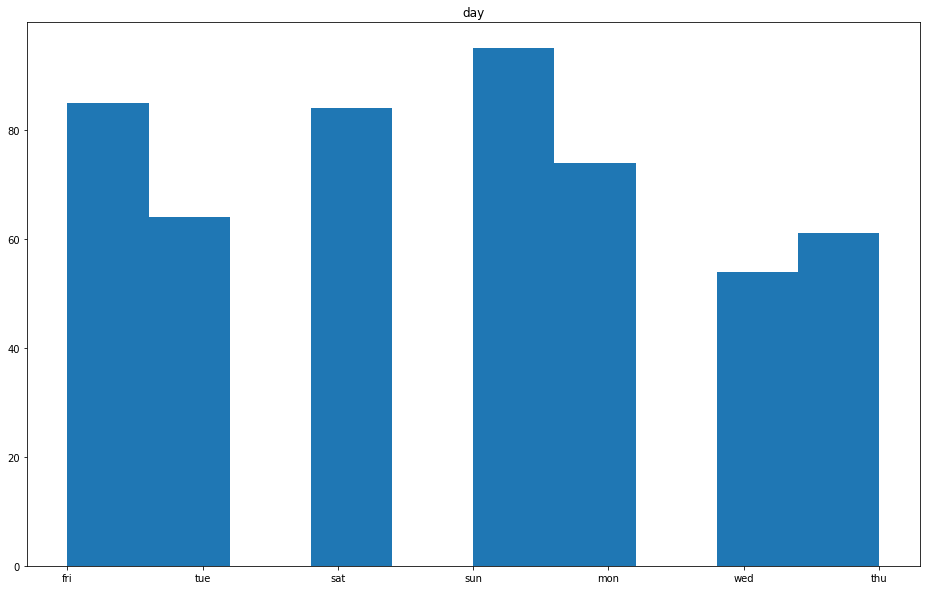

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

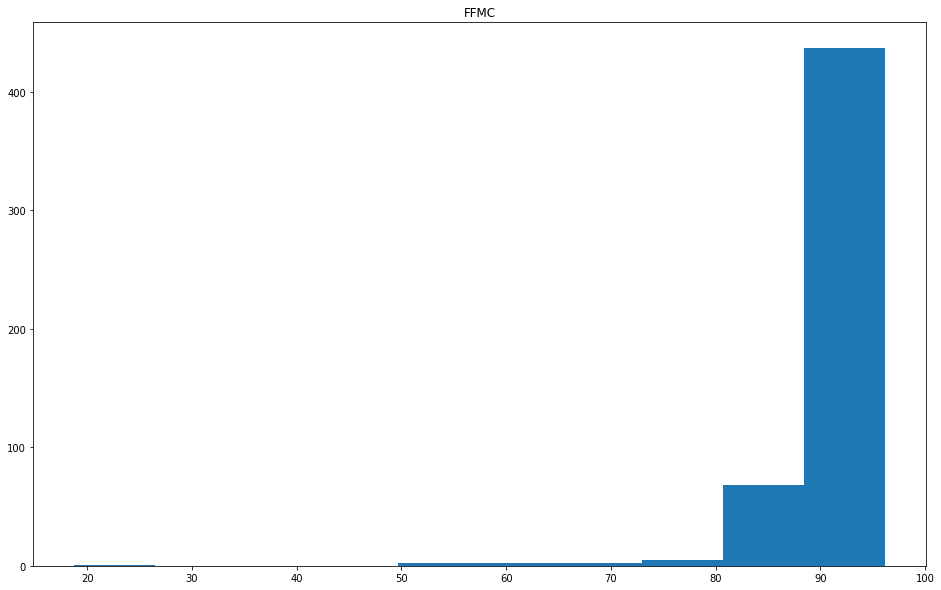

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

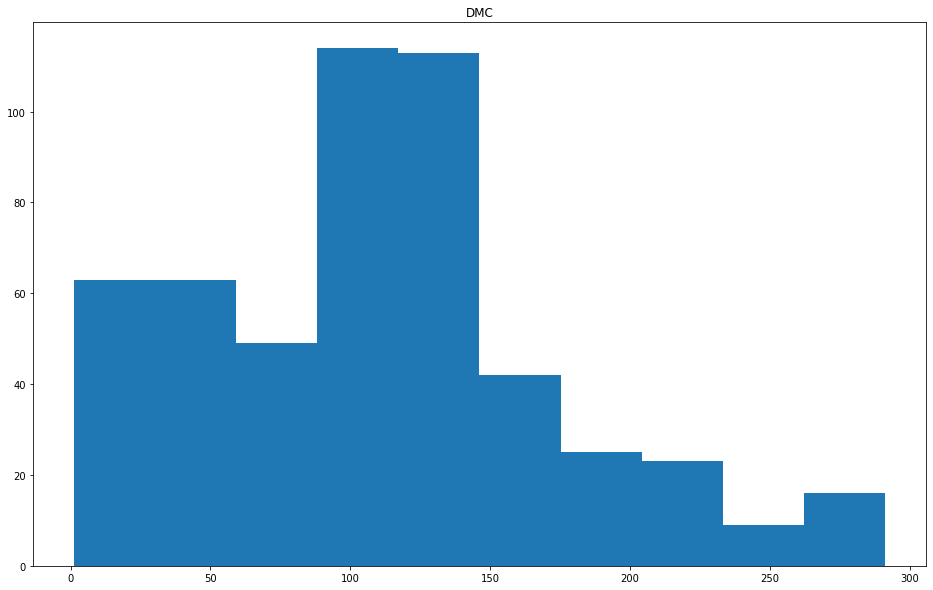

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

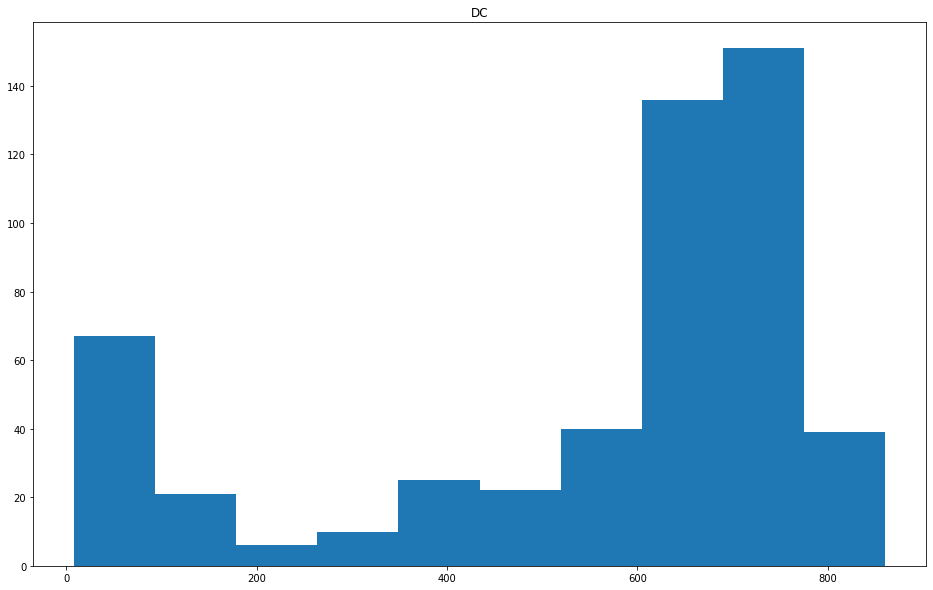

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

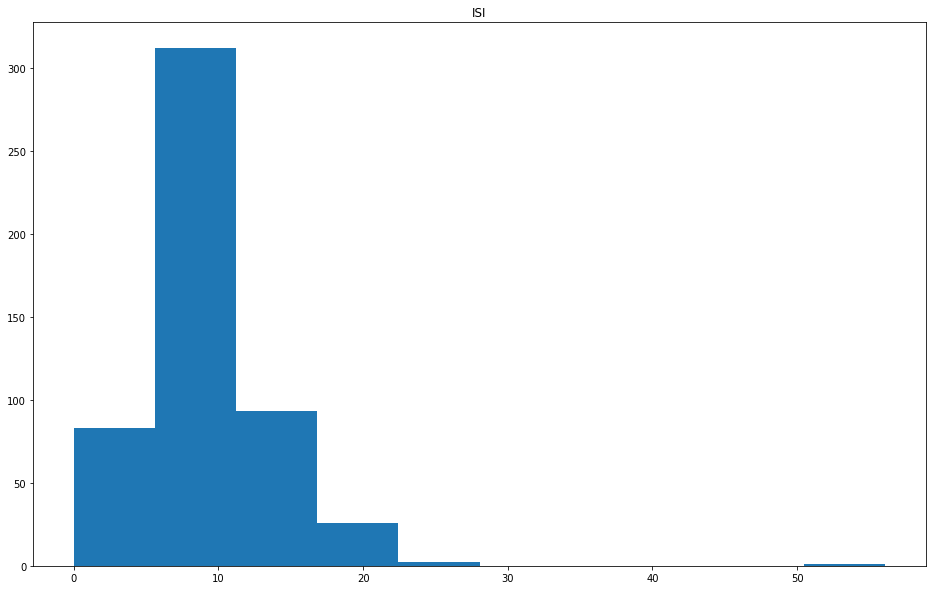

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

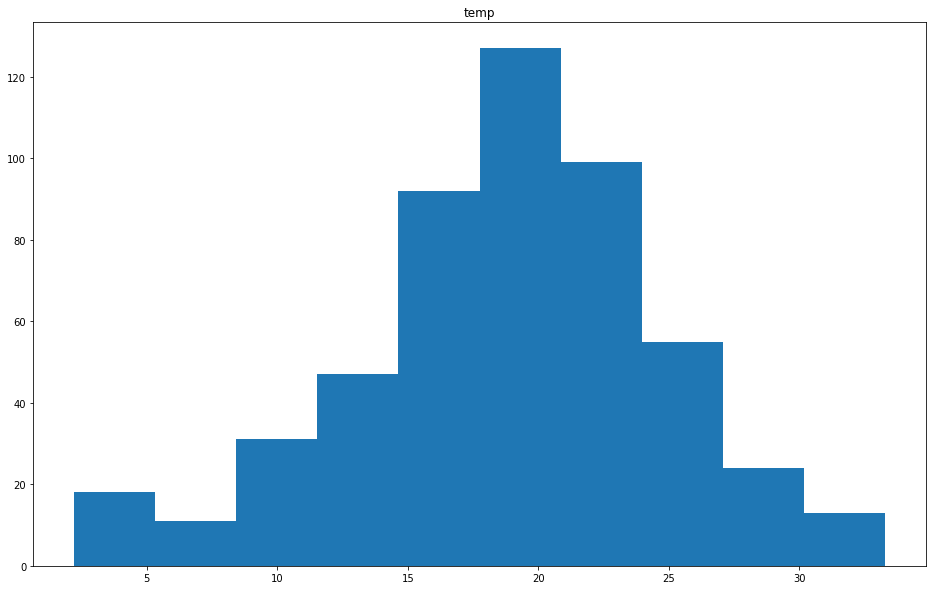

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

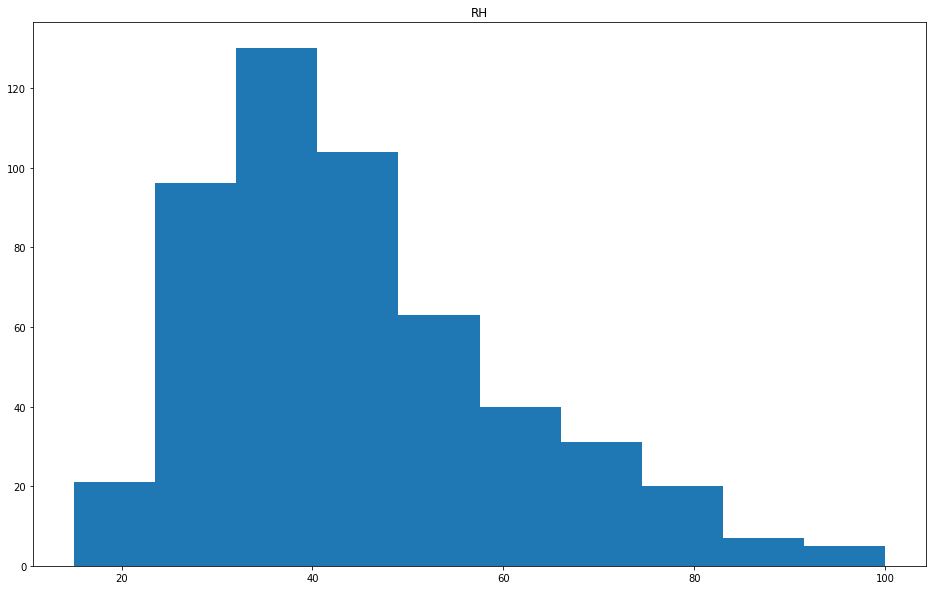

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

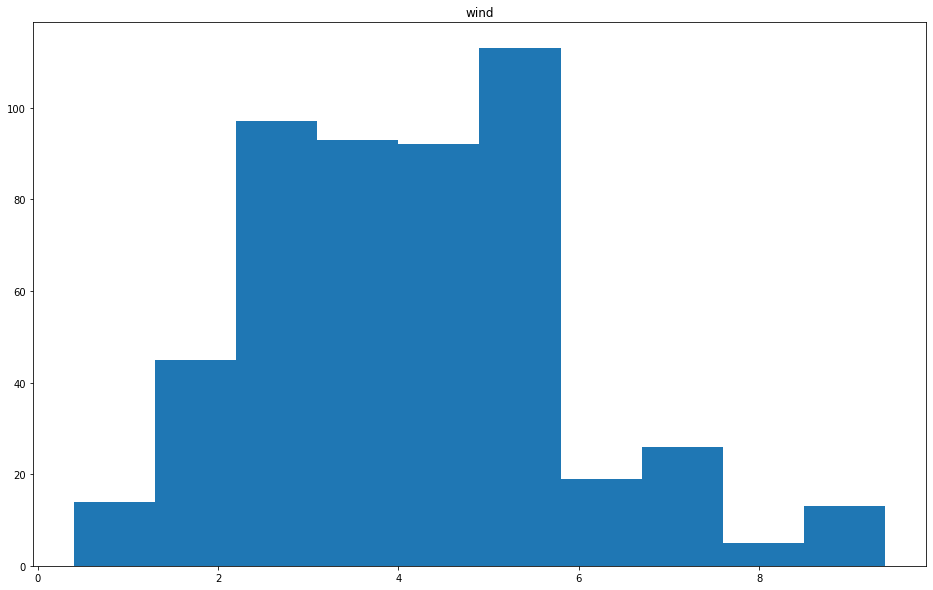

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

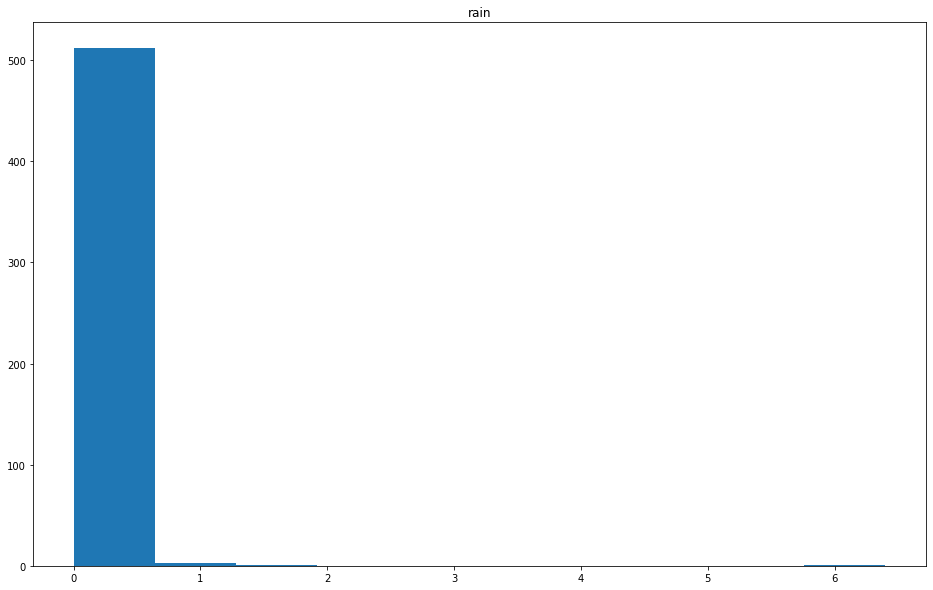

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

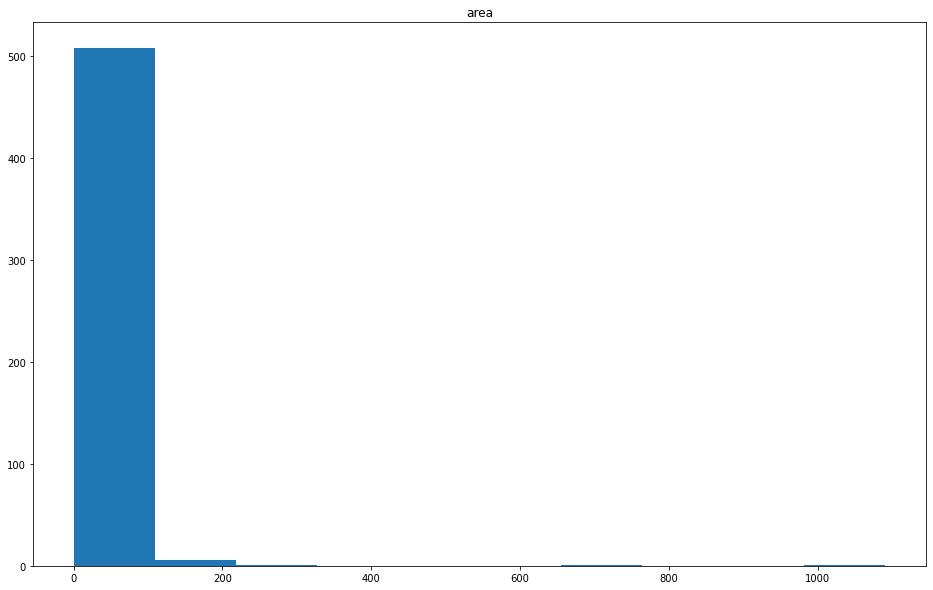

<IPython.core.display.Javascript object>

In [281]:
wrapp.get_hist_in_tabs(wrapp.dataset, wrapp.all_vars)

- Замечаем, что некоторые распределения выглядят как нормальное (пусть и с небольшими выбросами).

- Например, исключение - координаты Х и У. Это можно объяснить хотя бы тем, что ландшафт парка нам неизвестен, а следовательно и расположения деревьев, и очаги распространения пожаров. Следовательно распределение не может быть нормальным.

- Интерес представляет гистрограмма "month" и "day", на которых можно отметить следующее:
 1. Преимущественно пожары происходят в теплое время года. 
 2. Чаще пожары случаются в предвыходные и выходные дни (пятница, суббота, воскресенье)

Оба замечания согласуются со здравым смыслом: летом - жарко, а на выходных люди отдыхают. 

Вероятно, нет смысла кодировать месяца года от 1 до 12. Проще разделить на "летнее" и "не летнее" время года все месяца.

Попробуем это сделать:

In [268]:
def is_summertime(expr) -> int:
  return ((expr == "jun") | (expr == "jul") | (expr == "aug") | (expr == "sep"))

def is_weekend(expr) -> int:
  return ((expr == 'sat') | (expr == 'sun'))

In [282]:
transform_ds = pd.DataFrame(wrapp.dataset)
# 
transform_ds['month'] = is_summertime(transform_ds['month'])
transform_ds = transform_ds.rename(columns = {"month" : "summertime"})
#
transform_ds['day'] = is_weekend(transform_ds['day'])
transform_ds = transform_ds.rename(columns = {"day" : "weekend"})
#
wrapp.dataset = transform_ds
wrapp.feature_vars = ['X', 'Y', 'summertime', 'weekend', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

- Видим небольшой перекос и надеемся на то, что он не сломает дальнейшее обучение.

- По аналогии обрабатываем выходные дни:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


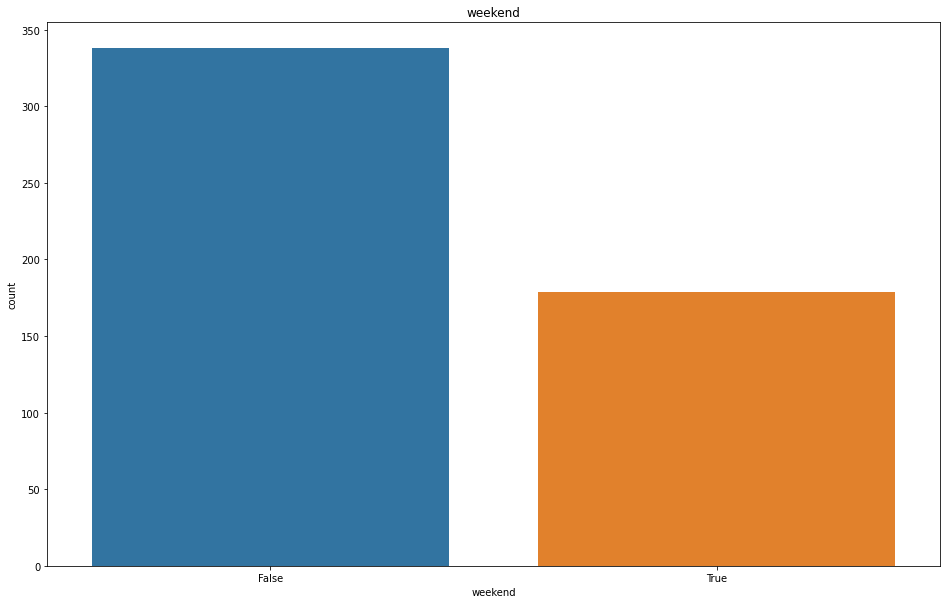

In [270]:
wrapp.get_pretty_hist("weekend")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


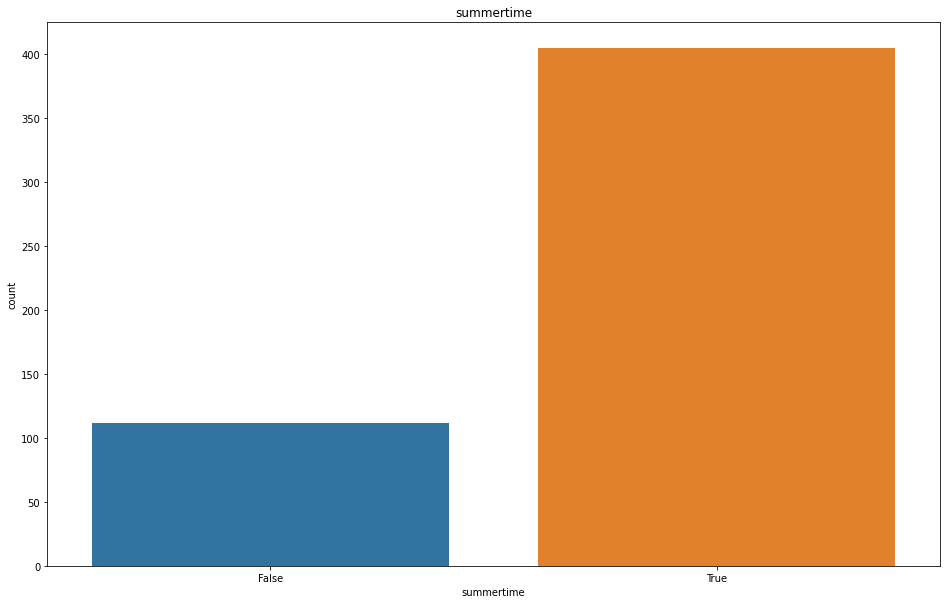

In [235]:
wrapp.get_pretty_hist("summertime")

In [283]:
strange_hists = ['rain', 'area']

transform_ds.loc[:, strange_hists] = transform_ds.loc[:, strange_hists].apply(lambda x: np.log(x + 1), axis = 1)
wrapp.dataset = transform_ds

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

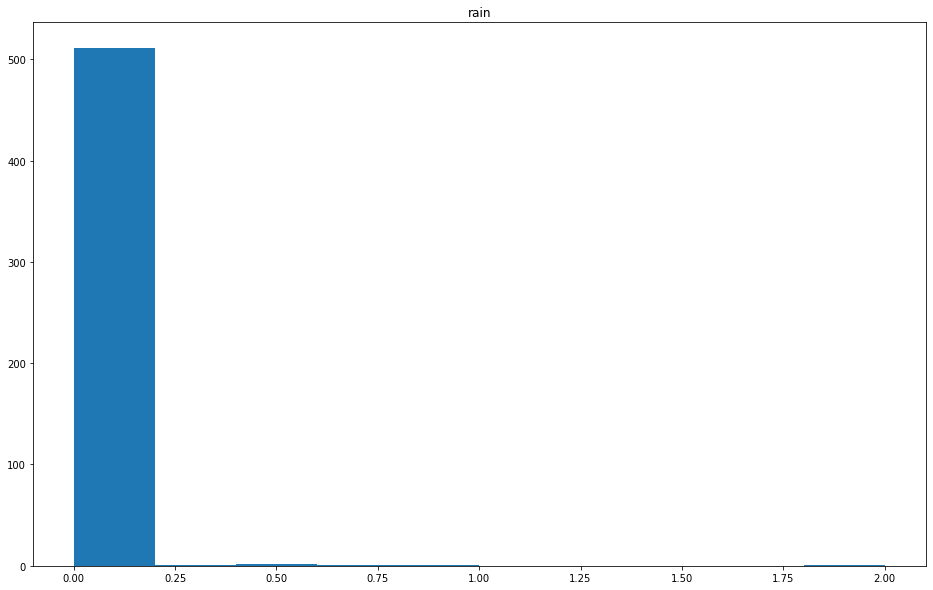

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

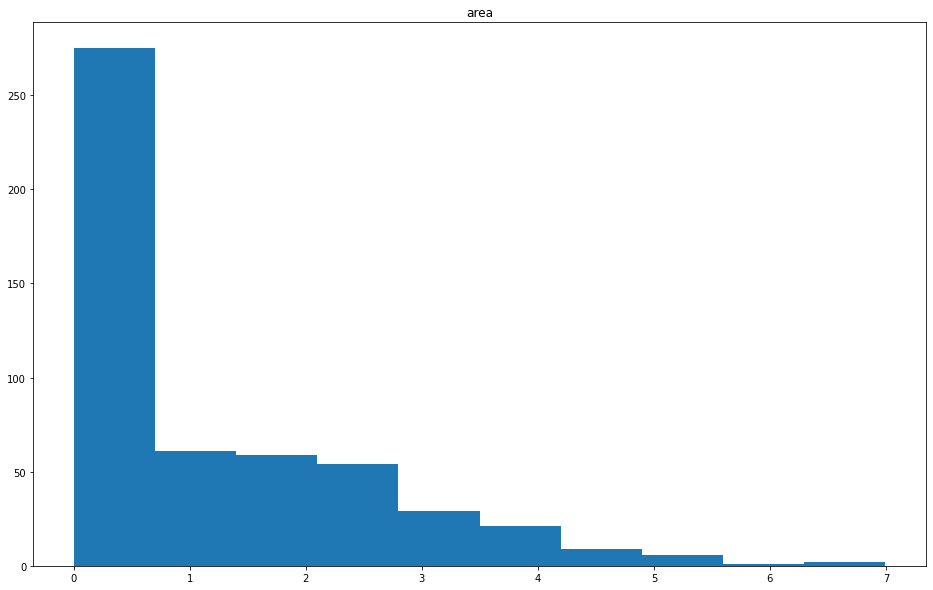

<IPython.core.display.Javascript object>

In [284]:
wrapp.get_hist_in_tabs(wrapp.dataset, strange_hists)

### Разделим исходный датасет на features, target. А после преобразованные данные делим на части train и test примерно так, как показано на картинке.

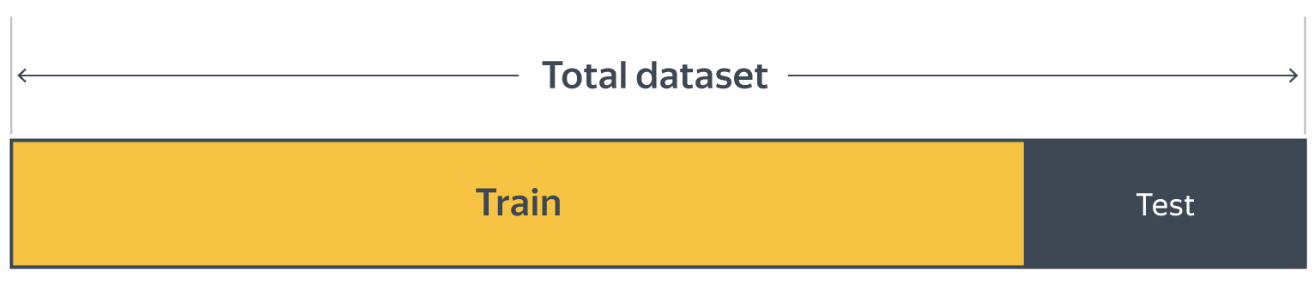

In [285]:
wrapp.split_dataset(dataset=wrapp.dataset, target_var=wrapp.target_vars, testsize=0.25, random_st = 4)

In [286]:
wrapp.scale_features()
wrapp.scale_target()

## Рассмотим для полученного train датасета:
  1. Гистограмму для всех features.
  2. Кореляционную heatmap'у между featres, target переменными.

In [287]:
# Need to cast to get corr matrix
wrapp.data2dataframe()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

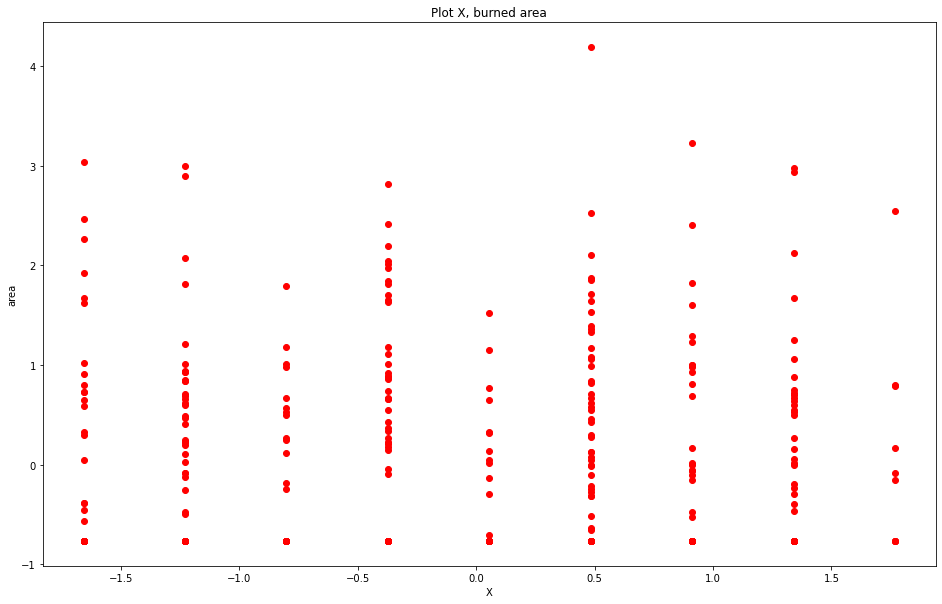

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

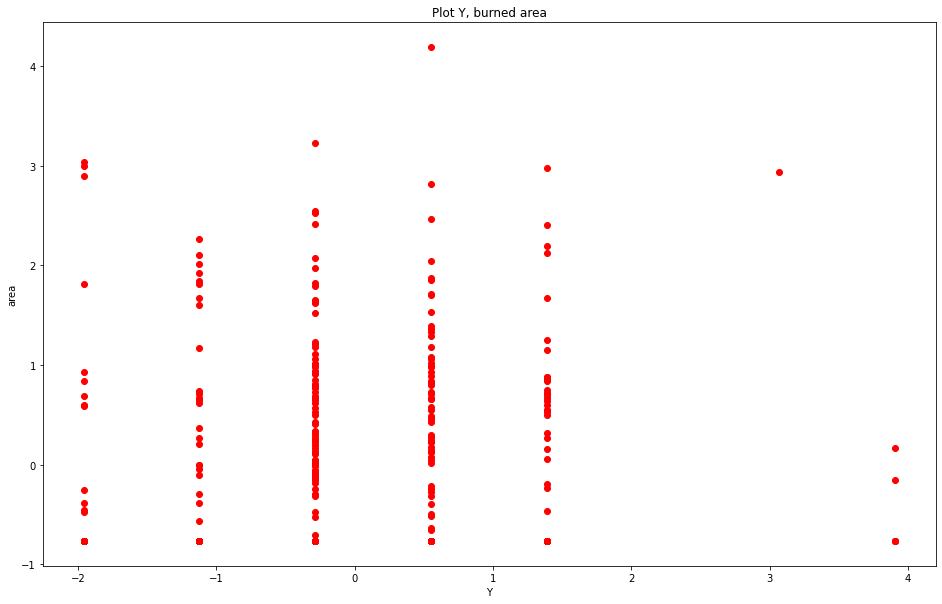

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

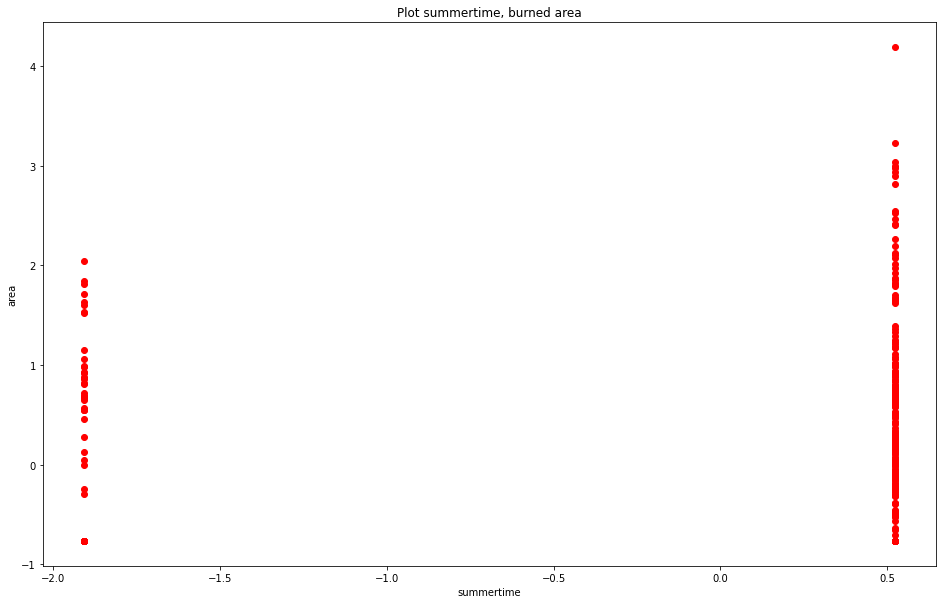

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

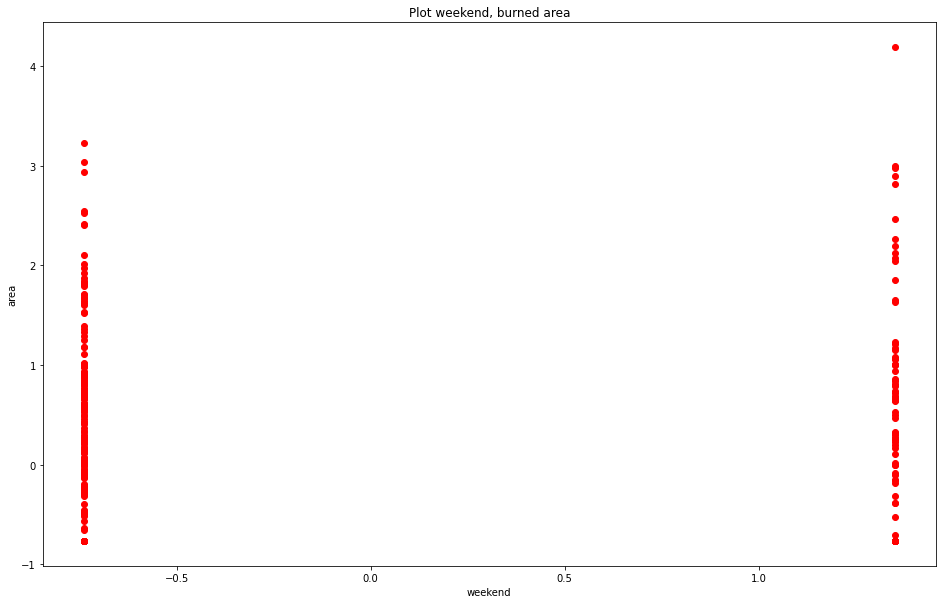

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

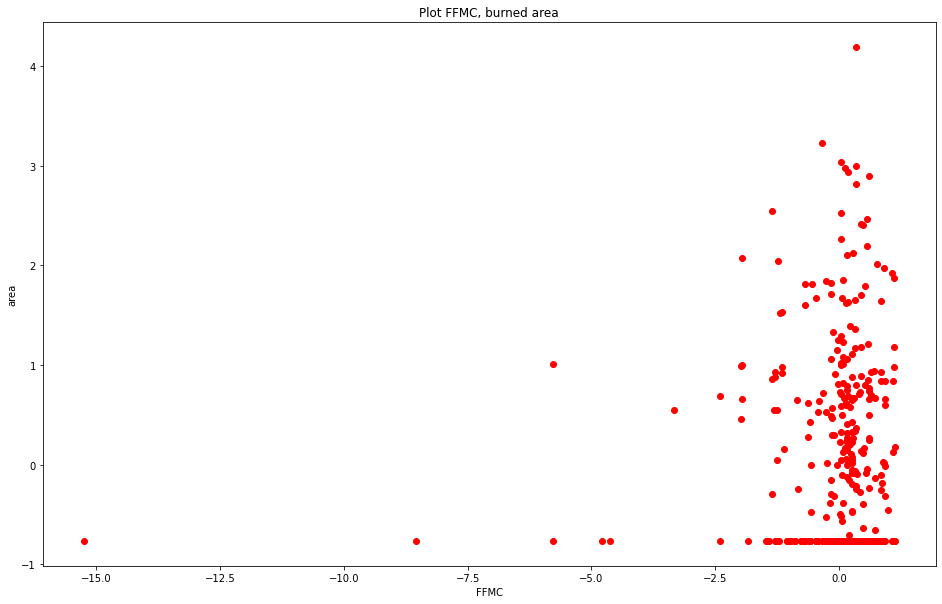

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

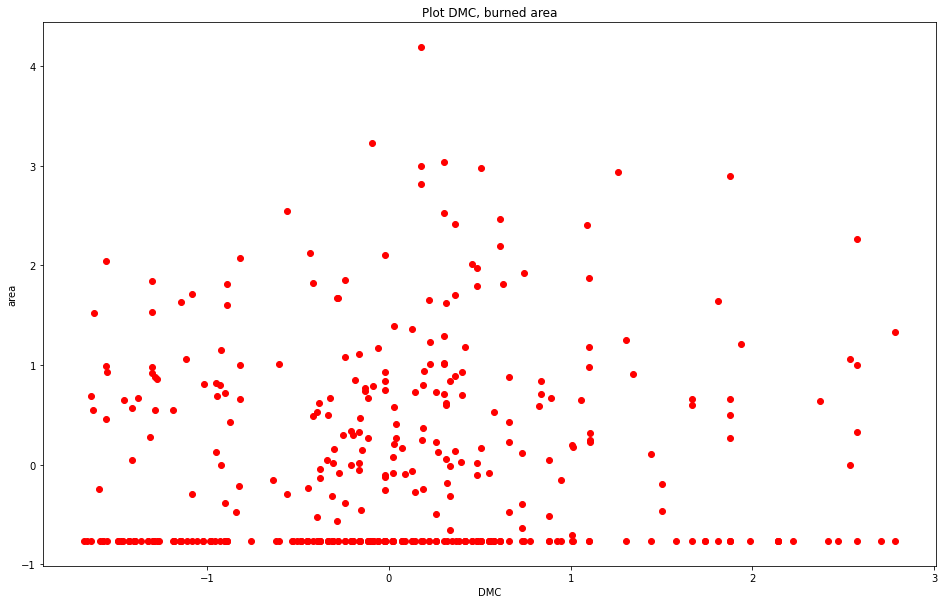

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

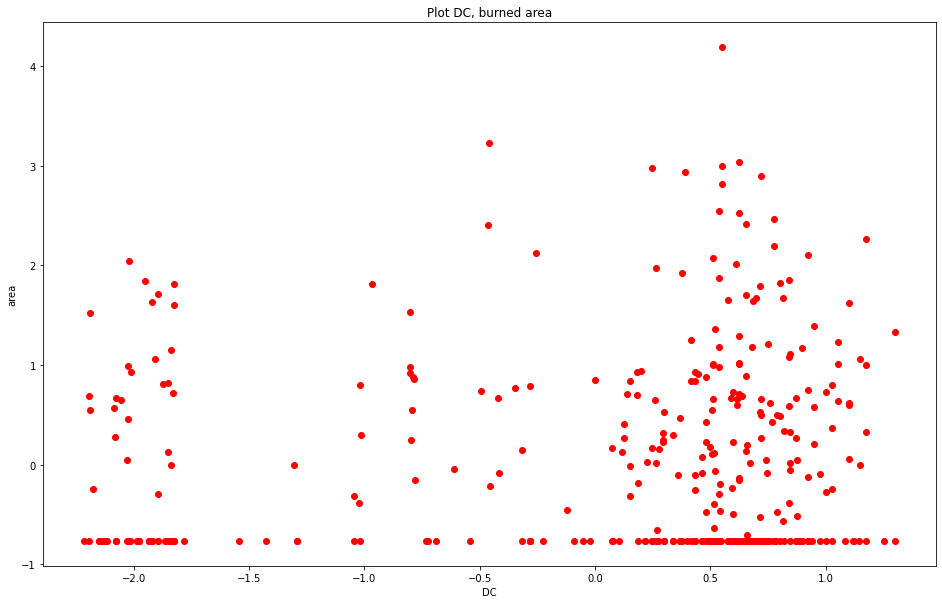

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

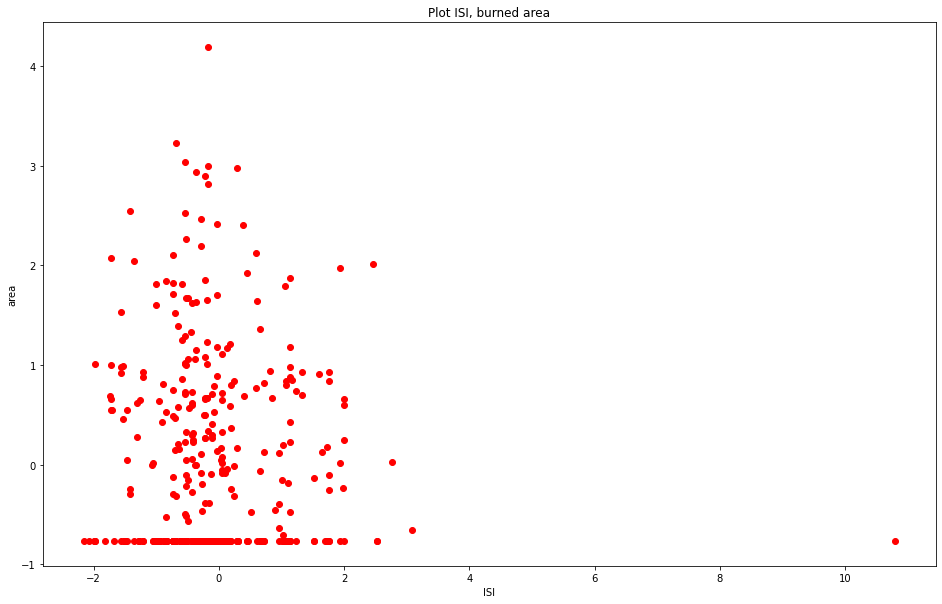

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

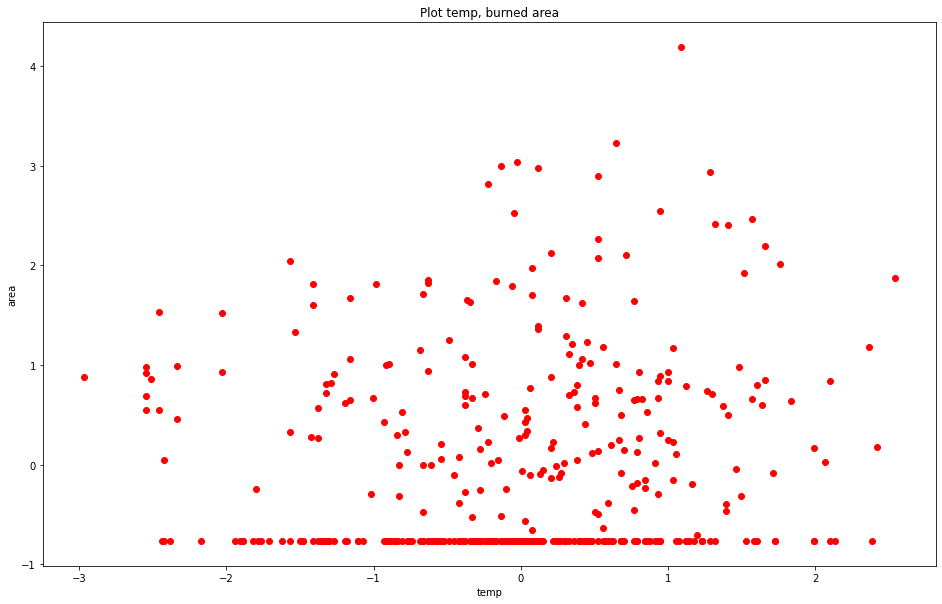

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

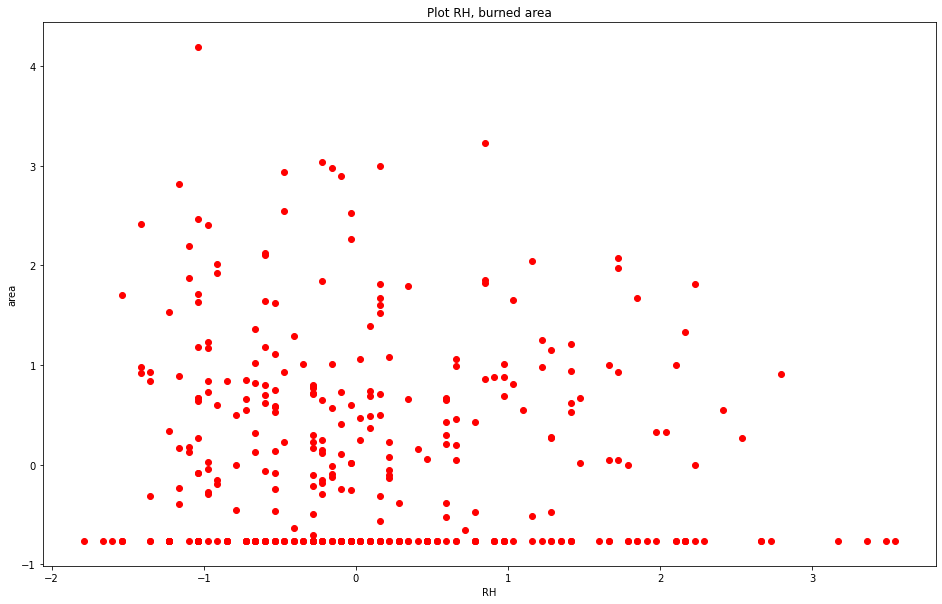

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

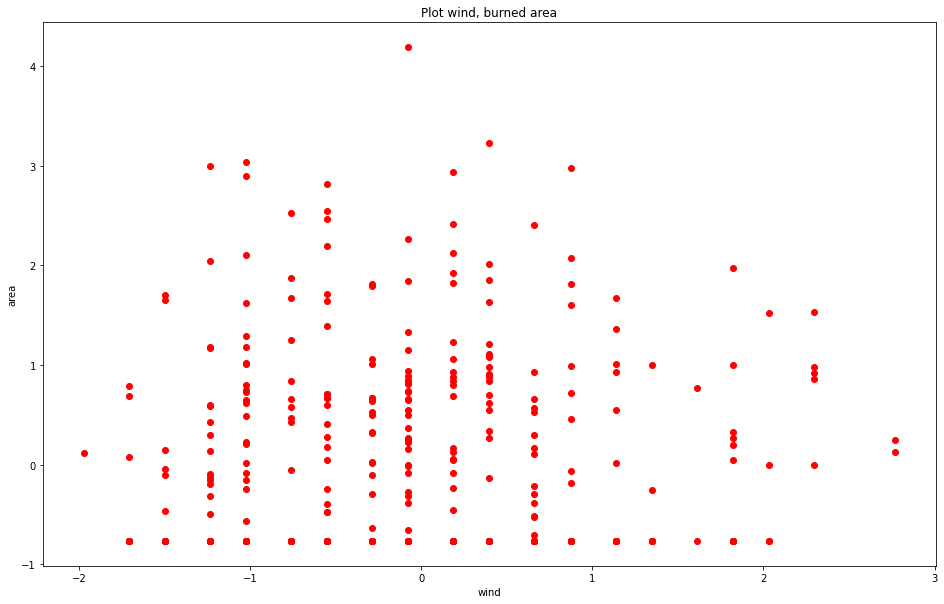

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

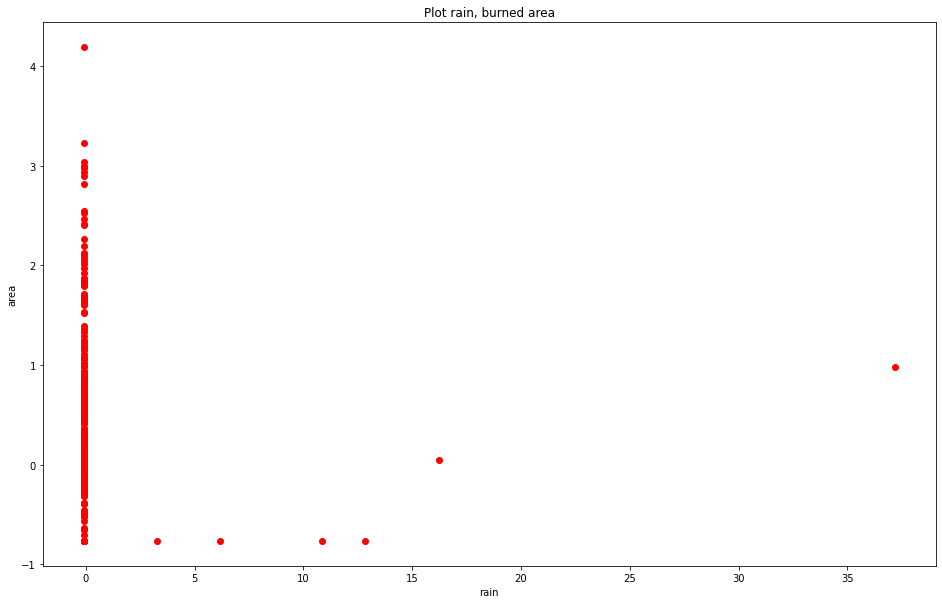

<IPython.core.display.Javascript object>

In [288]:
wrapp.get_plot_in_tabs(wrapp.features_train, wrapp.target_train, wrapp.feature_vars)

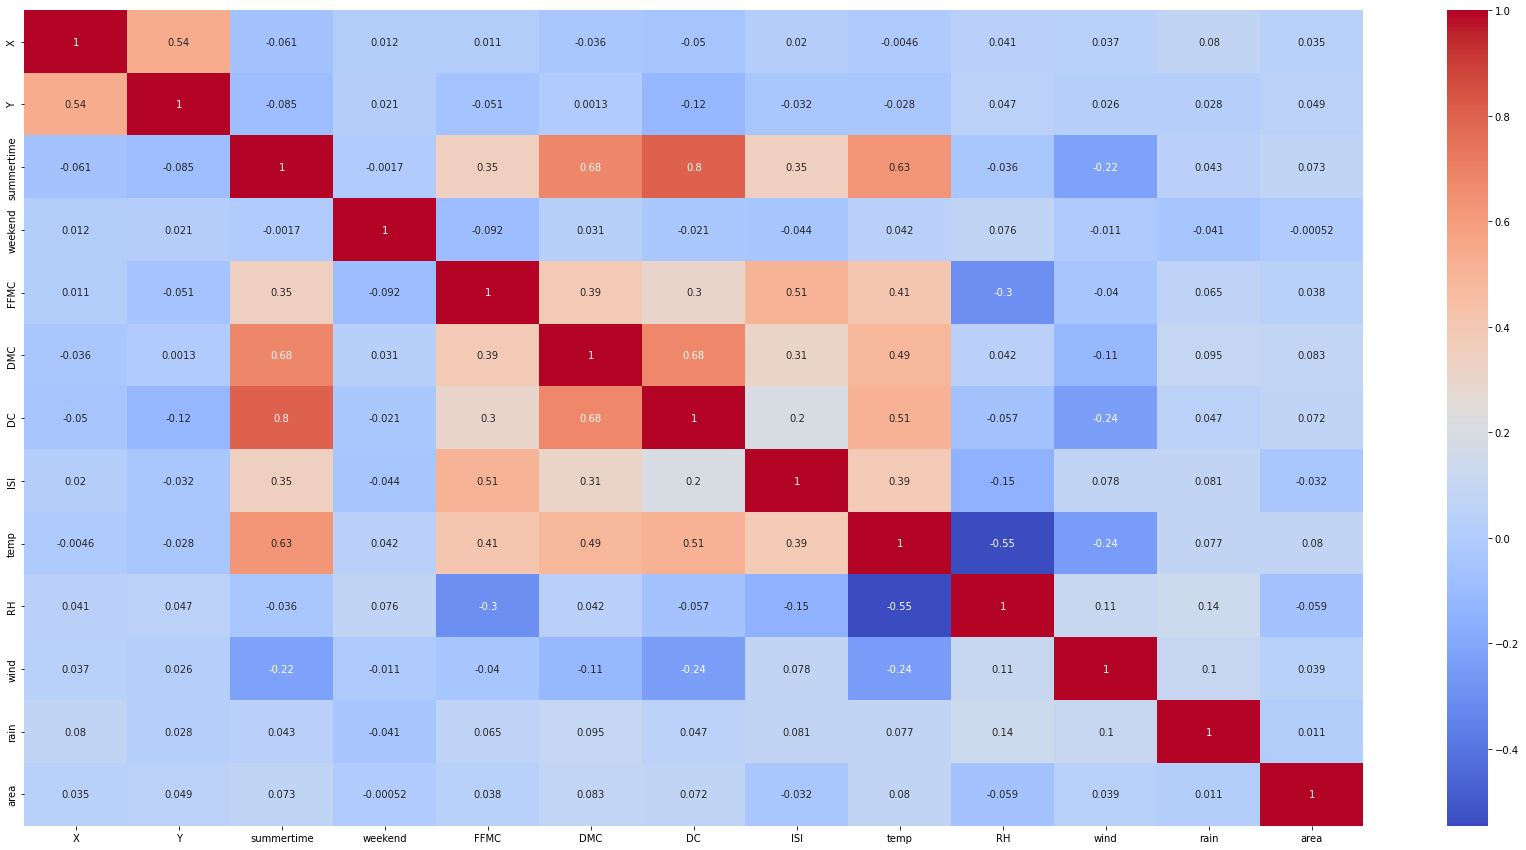

In [289]:
# 2
wrapp.get_corr(join_data(wrapp.features_train, wrapp.target_train))

In [277]:
check_vif(wrapp.features_train)

X             1.452150
Y             1.472500
summertime    4.329426
weekend       1.045375
FFMC          1.636967
DMC           2.447819
DC            3.403655
ISI           1.560083
temp          3.596946
RH            2.284850
wind          1.153277
rain          1.111959
dtype: float64


In [290]:
new_features = list(["summertime", "DMC", "DC", "temp", "RH"])
wrapp.upd_features(new_features)

# Neet to cast to work w/ prediction models: linear regression, FDN, prerceptron
wrapp.data2numpyarr()

## 2. Реализация линейной регрессии:

For the train set the r2 is: 0.011101344282770653
The RMSE is: 0.9819285192169079
For the train set the r2 is: -0.004902062839535981
The RMSE is: 1.0024480349821312


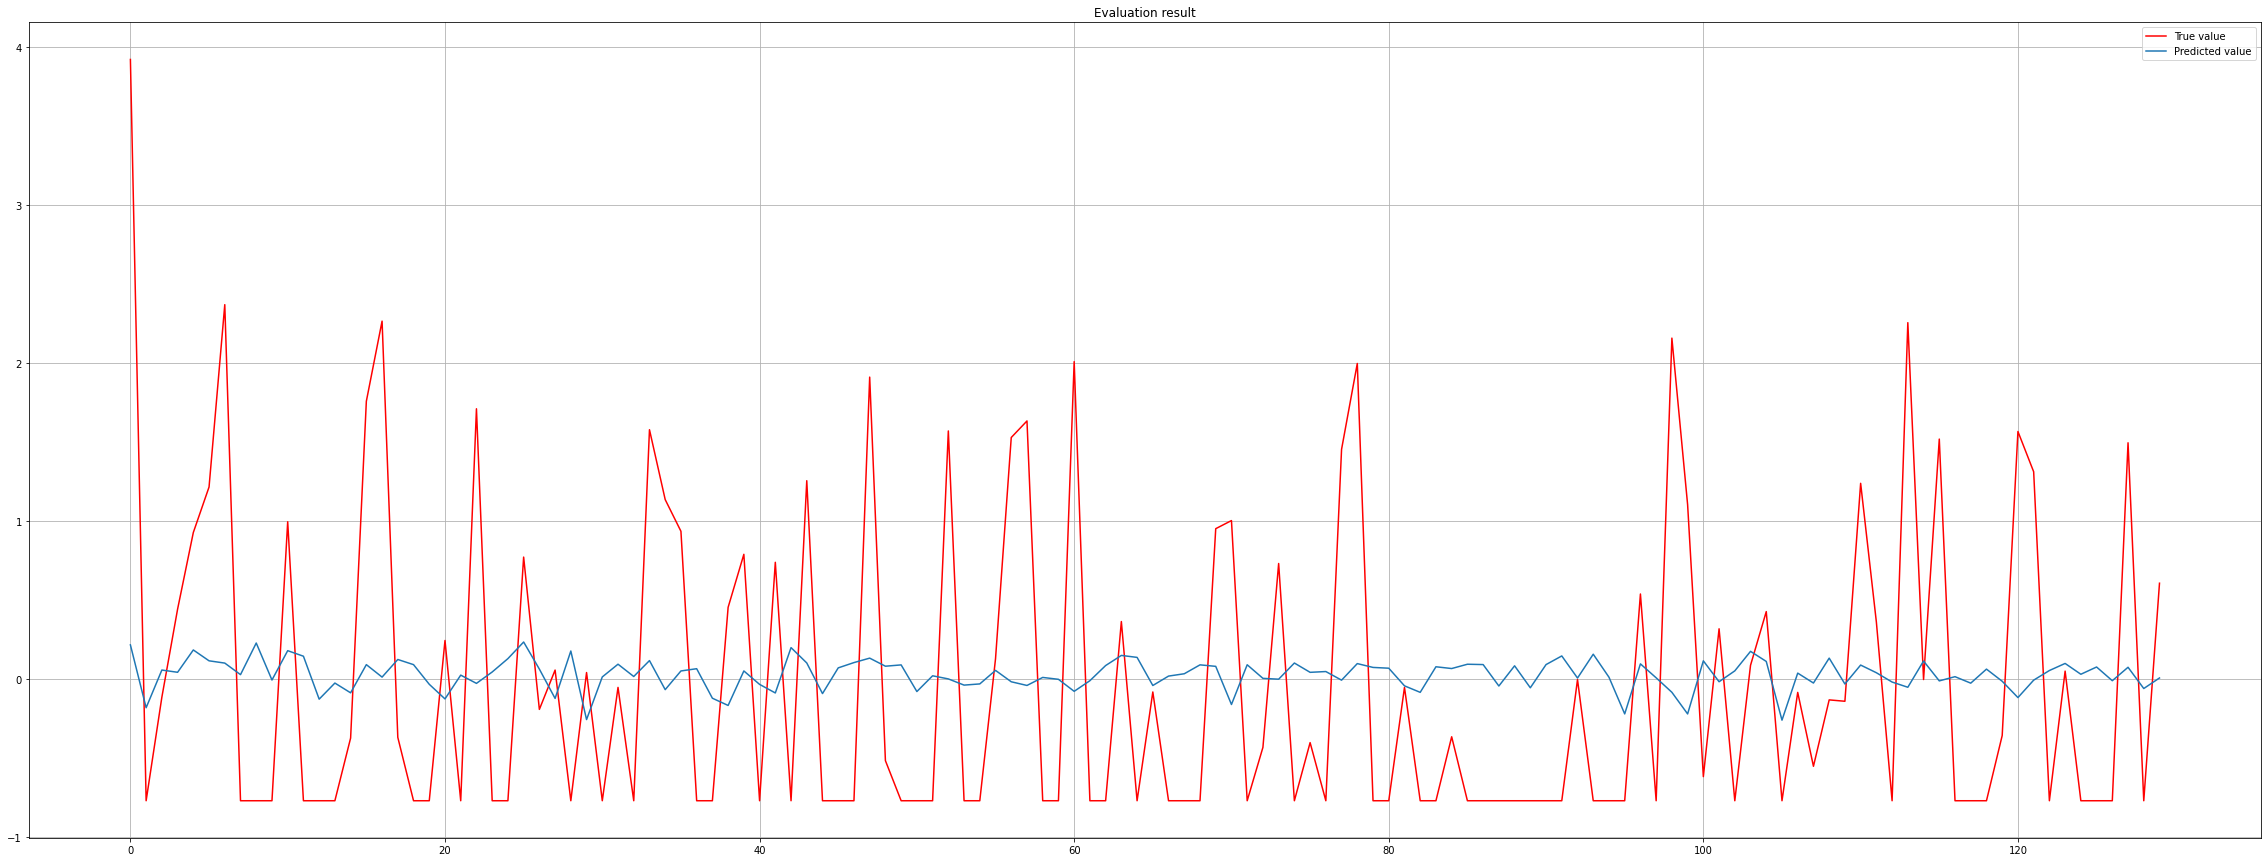

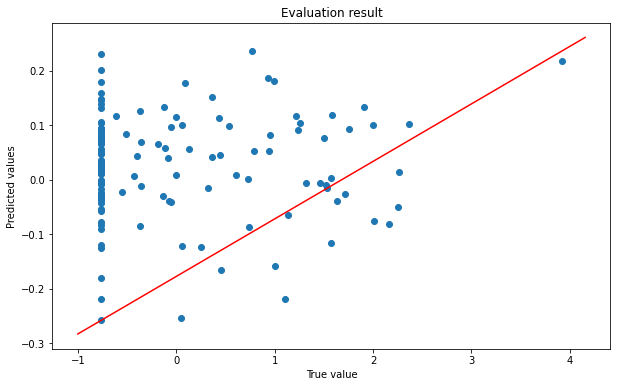

In [291]:
model = LinearRegression().fit(wrapp.features_train, wrapp.target_train)
target_test_predict, r2 = wrapp.run_model(model, True)
wrapp.plot_compare(target_test_predict)
wrapp.evaluation(target_test_predict)

## 3. Реализация модели, основанной на формуле Надарая Ватсона

In [292]:
from scipy.spatial.distance import cdist
#implementation of formula
class FNV(object):
    def __init__(self, kernel=None):
        self.X, self.Y = None, None
        self.kernel = lambda x: np.ones_like(x)
        if kernel is not None:
            self.kernel = kernel

    def predict(self, X):
        features = np.sum(self.Y * self.kernel(cdist(X, self.X)), axis=-1)
        return features / (np.sum(self.kernel(cdist(X, self.X)), axis=-1) + 1e-10)
        
    def fit(self, X, Y):
        self.X, self.Y = np.array(X), np.array(Y)

In [297]:
# NOTE: kernel implementation
def K(distance, h=0.2):
    ret = np.array(distance) / h
    return (1 - ret**2) * (np.abs(ret) <= 1)

# NOTE: function to get h-param for better r2 score to test dataset
def get_optimal_h():
  max = 0
  h_opt = 2

  for h_i in range(0, 100):
    h = h_i * 0.1 + 0.1
    model = FNV(kernel=lambda x: K(x, h=h))
    model.fit(wrapp.features_train, wrapp.target_train) 
    fnv_target_test_predict, r2 = wrapp.run_model(model)
    #
    print(f'{h:.1f}, {r2:.5f}')
    #
    if (max < r2):
      max = r2  
      h_opt = h

  print(f'Optimal h = {h_opt:.1f}, r2_score = {max:.5f}')
  return h_opt

In [298]:
h_opt = get_optimal_h()
model_fnv = FNV(kernel=lambda x: K(x, h=h_opt))
model_fnv.fit(wrapp.features_train, wrapp.target_train)

0.1, -0.18432
0.2, -0.42248
0.3, -0.64312
0.4, -0.46984
0.5, -0.30623
0.6, -0.20171
0.7, -0.20109
0.8, -0.22381
0.9, -0.22089
1.0, -0.20328
1.1, -0.17699
1.2, -0.13626
1.3, -0.09570
1.4, -0.06907
1.5, -0.04799
1.6, -0.03789
1.7, -0.03069
1.8, -0.02710
1.9, -0.02569
2.0, -0.02542
2.1, -0.02717
2.2, -0.02751
2.3, -0.02655
2.4, -0.02726
2.5, -0.02854
2.6, -0.02882
2.7, -0.02485
2.8, -0.01807
2.9, -0.01222
3.0, -0.00742
3.1, -0.00393
3.2, -0.00225
3.3, -0.00141
3.4, -0.00109
3.5, -0.00126
3.6, -0.00134
3.7, -0.00141
3.8, -0.00174
3.9, -0.00199
4.0, -0.00205
4.1, -0.00237
4.2, -0.00280
4.3, -0.00329
4.4, -0.00327
4.5, -0.00343
4.6, -0.00353
4.7, -0.00350
4.8, -0.00352
4.9, -0.00337
5.0, -0.00320
5.1, -0.00304
5.2, -0.00287
5.3, -0.00270
5.4, -0.00250
5.5, -0.00228
5.6, -0.00212
5.7, -0.00196
5.8, -0.00190
5.9, -0.00182
6.0, -0.00174
6.1, -0.00165
6.2, -0.00156
6.3, -0.00149
6.4, -0.00143
6.5, -0.00137
6.6, -0.00132
6.7, -0.00126
6.8, -0.00119
6.9, -0.00113
7.0, -0.00108
7.1, -0.00105
7.2, -

For the train set the r2 is: 0.053502005073464254
The RMSE is: 0.9606469976599648
For the train set the r2 is: -0.025420924100965747
The RMSE is: 1.0126306948246067


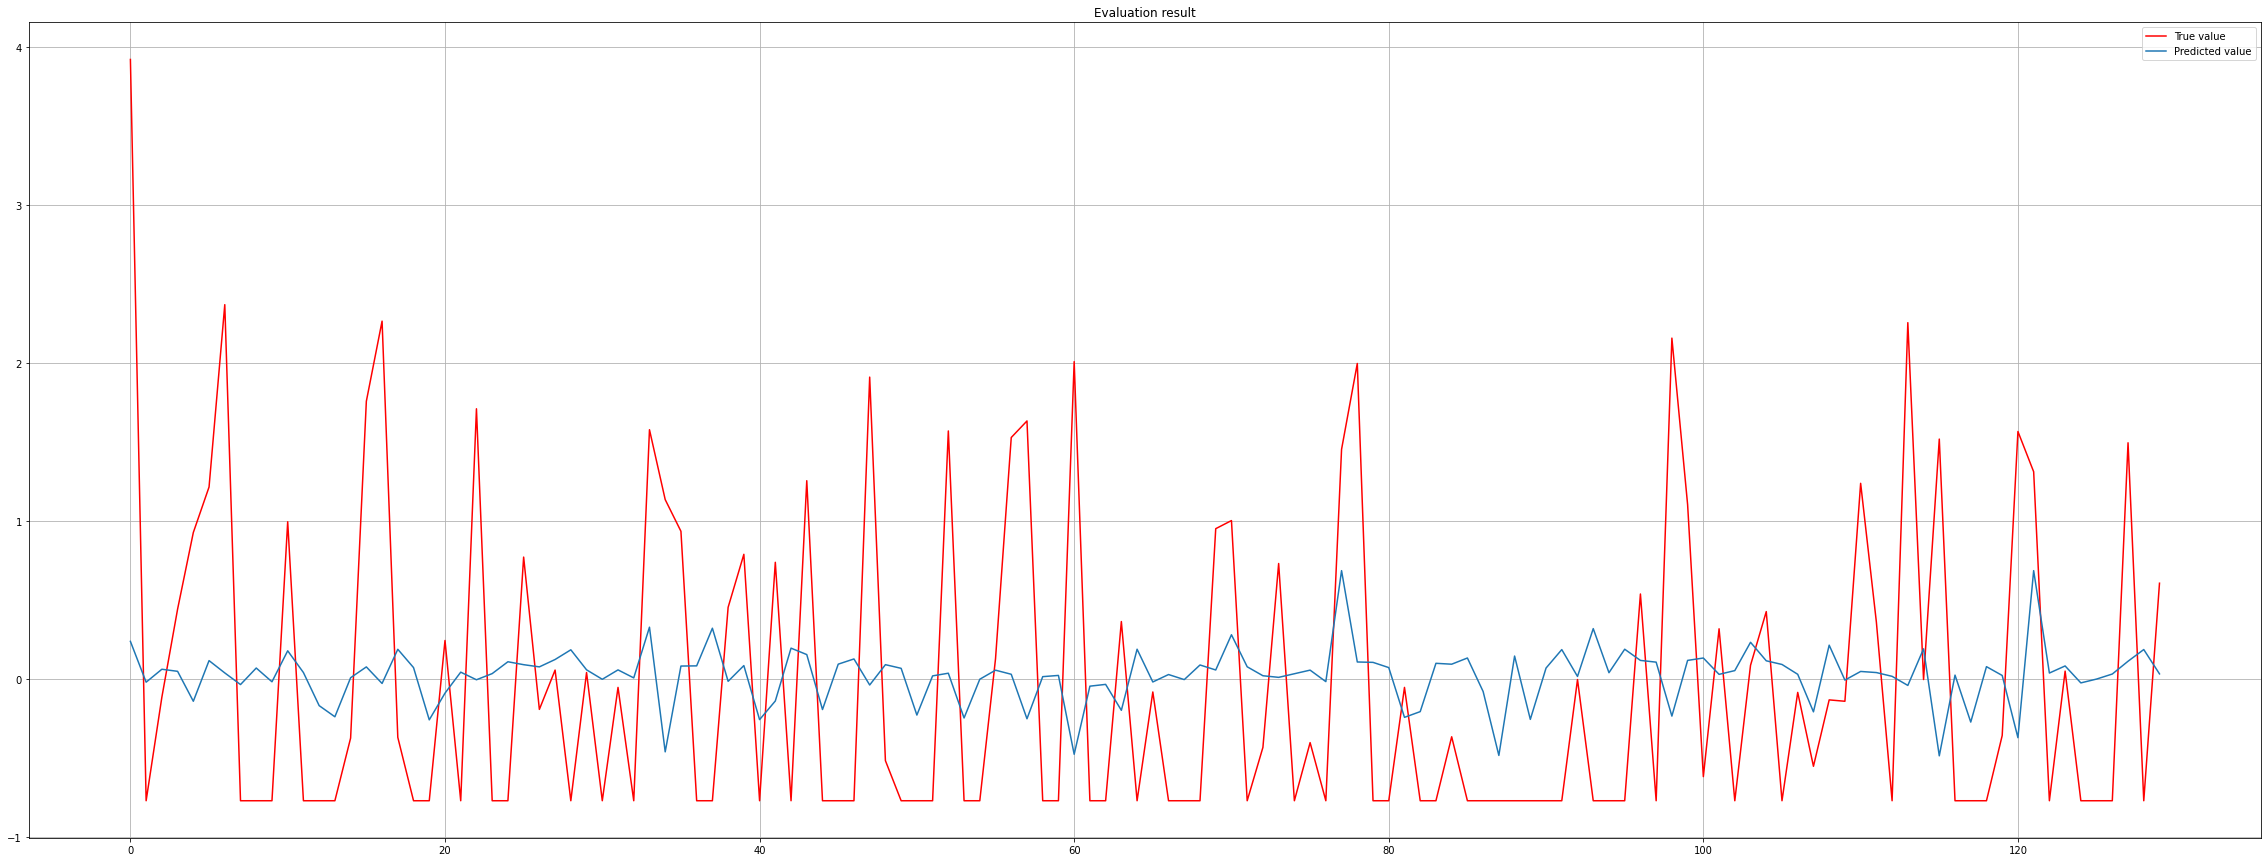

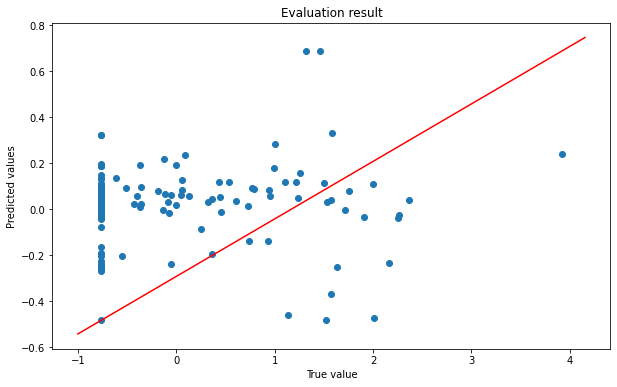

In [299]:
fnv_target_test_predict, r2 = wrapp.run_model(model_fnv, True)
wrapp.plot_compare(fnv_target_test_predict)
wrapp.evaluation(fnv_target_test_predict)

## 4. Реализация модели перцептрона

In [301]:
from sklearn.neural_network import MLPRegressor

In [302]:
#Choosing random_state
state_opt = 1
max = 0
for state in range(1, 11):
  perc = MLPRegressor(random_state=state, max_iter = 10000, hidden_layer_sizes = (65,), alpha=0.1, validation_fraction=0.025, early_stopping = True)#creating perceptron model
  perc.fit(wrapp.features_train, wrapp.target_train)

  target_test_predct, r2 = wrapp.run_model(perc)
  print(f'{state}, {r2:.5f}')
  if (max < r2):
    max = r2
    state_opt = state
print(f'Optimal random_state = {state_opt}, r2_score = {max:.5f}')

1, 0.00114
2, -0.05984
3, -0.00490
4, -0.20791
5, -0.03791
6, -0.00912
7, 0.03226
8, -0.02374
9, -0.01867
10, 0.00815
Optimal random_state = 7, r2_score = 0.03226


In [303]:
#Choosing count of layers and neurons
count_layers = 65
max = 0
count_neur = 1
for count in range(3, 10):
  for count_n in range(10, 200):
    perc = MLPRegressor(random_state=state_opt, max_iter = 10000, hidden_layer_sizes = tuple([count_n for _ in range(0, count)]), alpha=0.1, validation_fraction=0.025, early_stopping = True)
    perc.fit(wrapp.features_train, wrapp.target_train)
    
    prcp_target_test_predct, r2 = wrapp.run_model(perc)

    print(f'{count}, {count_n}, {r2:.5f}')
    if (max < r2):
      max = r2
      count_layers = count
      count_neur = count_n
print(f'Optimal count of layers = {count_layers}, optimal count of neurons = {count_neur}, r2_score = {max:.5f}')

3, 10, -0.03417
3, 11, -0.00930
3, 12, -0.42796
3, 13, -0.06075
3, 14, -0.00959
3, 15, -0.03847
3, 16, -0.02017
3, 17, -0.07032
3, 18, -0.01822
3, 19, -0.04743
3, 20, 0.00630
3, 21, -0.20916
3, 22, -0.12647
3, 23, -0.24812
3, 24, -0.01331
3, 25, -0.03092
3, 26, -0.17211
3, 27, -0.02188
3, 28, -0.05256
3, 29, 0.01051
3, 30, -0.08680
3, 31, -0.01800
3, 32, -0.00292
3, 33, -0.00177
3, 34, -0.05436
3, 35, -0.00682
3, 36, -0.01361
3, 37, -0.04990
3, 38, -0.03443
3, 39, -0.05032
3, 40, -0.01407
3, 41, 0.00577
3, 42, -0.03645
3, 43, -0.06930
3, 44, -0.35764
3, 45, -0.00621
3, 46, 0.00378
3, 47, -0.00690
3, 48, -0.27033
3, 49, -0.01368
3, 50, -0.02381
3, 51, 0.00175
3, 52, 0.01136
3, 53, -0.00118
3, 54, -0.01392
3, 55, -0.01113
3, 56, -0.04186
3, 57, -0.05309
3, 58, -0.04946
3, 59, -0.02649
3, 60, -0.00187
3, 61, -0.34128
3, 62, -0.00591
3, 63, -0.00009
3, 64, -0.00266
3, 65, -0.00132
3, 66, -0.16545
3, 67, -0.00108
3, 68, -0.00345
3, 69, -0.00091
3, 70, -0.01946
3, 71, -0.08681
3, 72, 0.00260

In [304]:
#Choosing alpha
alpha_opt = 0.1
max = 0
for alpha_i in range(1, 110):
  alpha = alpha_i * 0.01
  perc = MLPRegressor(random_state=state_opt, max_iter = 10000, hidden_layer_sizes = tuple([count_neur for _ in range(0, count_layers)]), alpha=alpha, validation_fraction=0.025, early_stopping = True)
  #
  perc.fit(wrapp.features_train, wrapp.target_train)
  prcp_target_test_predct, r2 = wrapp.run_model(perc)
  #
  print(f'{alpha:.2f}, {r2:.5f}')
  if (max < r2):
    max = r2
    alpha_opt = alpha

print(f'Optimal alpha = {alpha_opt:.2f}, r2_score = {max:.5f}')

0.01, 0.02854
0.02, 0.02857
0.03, 0.02856
0.04, 0.02859
0.05, 0.02857
0.06, 0.02859
0.07, 0.02860
0.08, 0.02859
0.09, 0.02850
0.10, 0.02848
0.11, 0.02851
0.12, 0.02851
0.13, 0.02850
0.14, 0.02852
0.15, 0.02844
0.16, 0.02839
0.17, 0.02837
0.18, 0.02832
0.19, 0.02831
0.20, 0.02831
0.21, 0.02831
0.22, 0.02828
0.23, 0.02829
0.24, 0.02829
0.25, 0.02832
0.26, 0.02831
0.27, 0.02830
0.28, 0.02832
0.29, 0.02833
0.30, 0.02833
0.31, 0.02835
0.32, 0.02830
0.33, 0.02826
0.34, 0.02822
0.35, 0.02824
0.36, 0.02824
0.37, 0.02827
0.38, 0.02829
0.39, 0.02826
0.40, 0.02825
0.41, 0.02827
0.42, 0.02825
0.43, 0.02827
0.44, 0.02828
0.45, 0.02826
0.46, 0.02828
0.47, 0.02828
0.48, 0.02828
0.49, 0.02828
0.50, 0.02832
0.51, 0.02834
0.52, 0.02831
0.53, 0.02831
0.54, 0.02835
0.55, 0.02835
0.56, 0.02837
0.57, 0.02834
0.58, 0.02835
0.59, 0.02833
0.60, 0.02838
0.61, 0.02837
0.62, 0.02836
0.63, 0.02836
0.64, 0.02838
0.65, 0.02839
0.66, 0.02840
0.67, 0.02842
0.68, 0.02843
0.69, 0.02842
0.70, 0.02841
0.71, 0.02842
0.72, 

In [305]:
#Choosing validation_fraction
validation_fraction_opt = 0
max = 0
for validation_fraction_i in range(300, 500, 5):
  validation_fraction = validation_fraction_i * 0.0001
  perc = MLPRegressor(random_state=state_opt, max_iter = 10000, hidden_layer_sizes = tuple([count_neur for _ in range(0, count_layers)]), alpha=alpha_opt, validation_fraction=validation_fraction, early_stopping = True)
  perc.fit(wrapp.features_train, wrapp.target_train) #fitting

  prcp_target_test_predct, r2 = wrapp.run_model(perc)

  print(f'{validation_fraction:.4f}, {r2:.5f}')
  if (max < r2):
    max = r2
    validation_fraction_opt = validation_fraction

print(f'Optimal validation_fraction = {validation_fraction_opt:.4f}, r2_score = {max:.5f}')

0.0300, 0.02538
0.0305, 0.02538
0.0310, 0.02538
0.0315, 0.02706
0.0320, 0.02706
0.0325, 0.02706
0.0330, 0.02706
0.0335, 0.02706
0.0340, 0.02553
0.0345, 0.02553
0.0350, 0.02553
0.0355, 0.02553
0.0360, 0.02553
0.0365, 0.02885
0.0370, 0.02885
0.0375, 0.02885
0.0380, 0.02885
0.0385, 0.02885
0.0390, 0.02632
0.0395, 0.02632
0.0400, 0.02632
0.0405, 0.02632
0.0410, 0.02632
0.0415, 0.02915
0.0420, 0.02915
0.0425, 0.02915
0.0430, 0.02915
0.0435, 0.02915
0.0440, 0.02866
0.0445, 0.02866
0.0450, 0.02866
0.0455, 0.02866
0.0460, 0.02866
0.0465, 0.02866
0.0470, 0.02540
0.0475, 0.02540
0.0480, 0.02540
0.0485, 0.02540
0.0490, 0.02540
0.0495, 0.02585
Optimal validation_fraction = 0.0415, r2_score = 0.02915


In [306]:
perc = MLPRegressor(random_state=state_opt, max_iter = 10000, hidden_layer_sizes = tuple([count_neur for _ in range(0, count_layers)]), alpha=alpha_opt, validation_fraction=validation_fraction_opt, early_stopping = True)
perc.fit(wrapp.features_train, wrapp.target_train)

MLPRegressor(alpha=0.07, early_stopping=True,
             hidden_layer_sizes=(167, 167, 167), max_iter=10000, random_state=7,
             validation_fraction=0.0415)

In [307]:
prcp_target_test_predct, r2 = wrapp.run_model(perc, True)

For the train set the r2 is: 0.01253307760775968
The RMSE is: 0.9812174407877325
For the train set the r2 is: 0.02914574962092964
The RMSE is: 0.9853193646625801


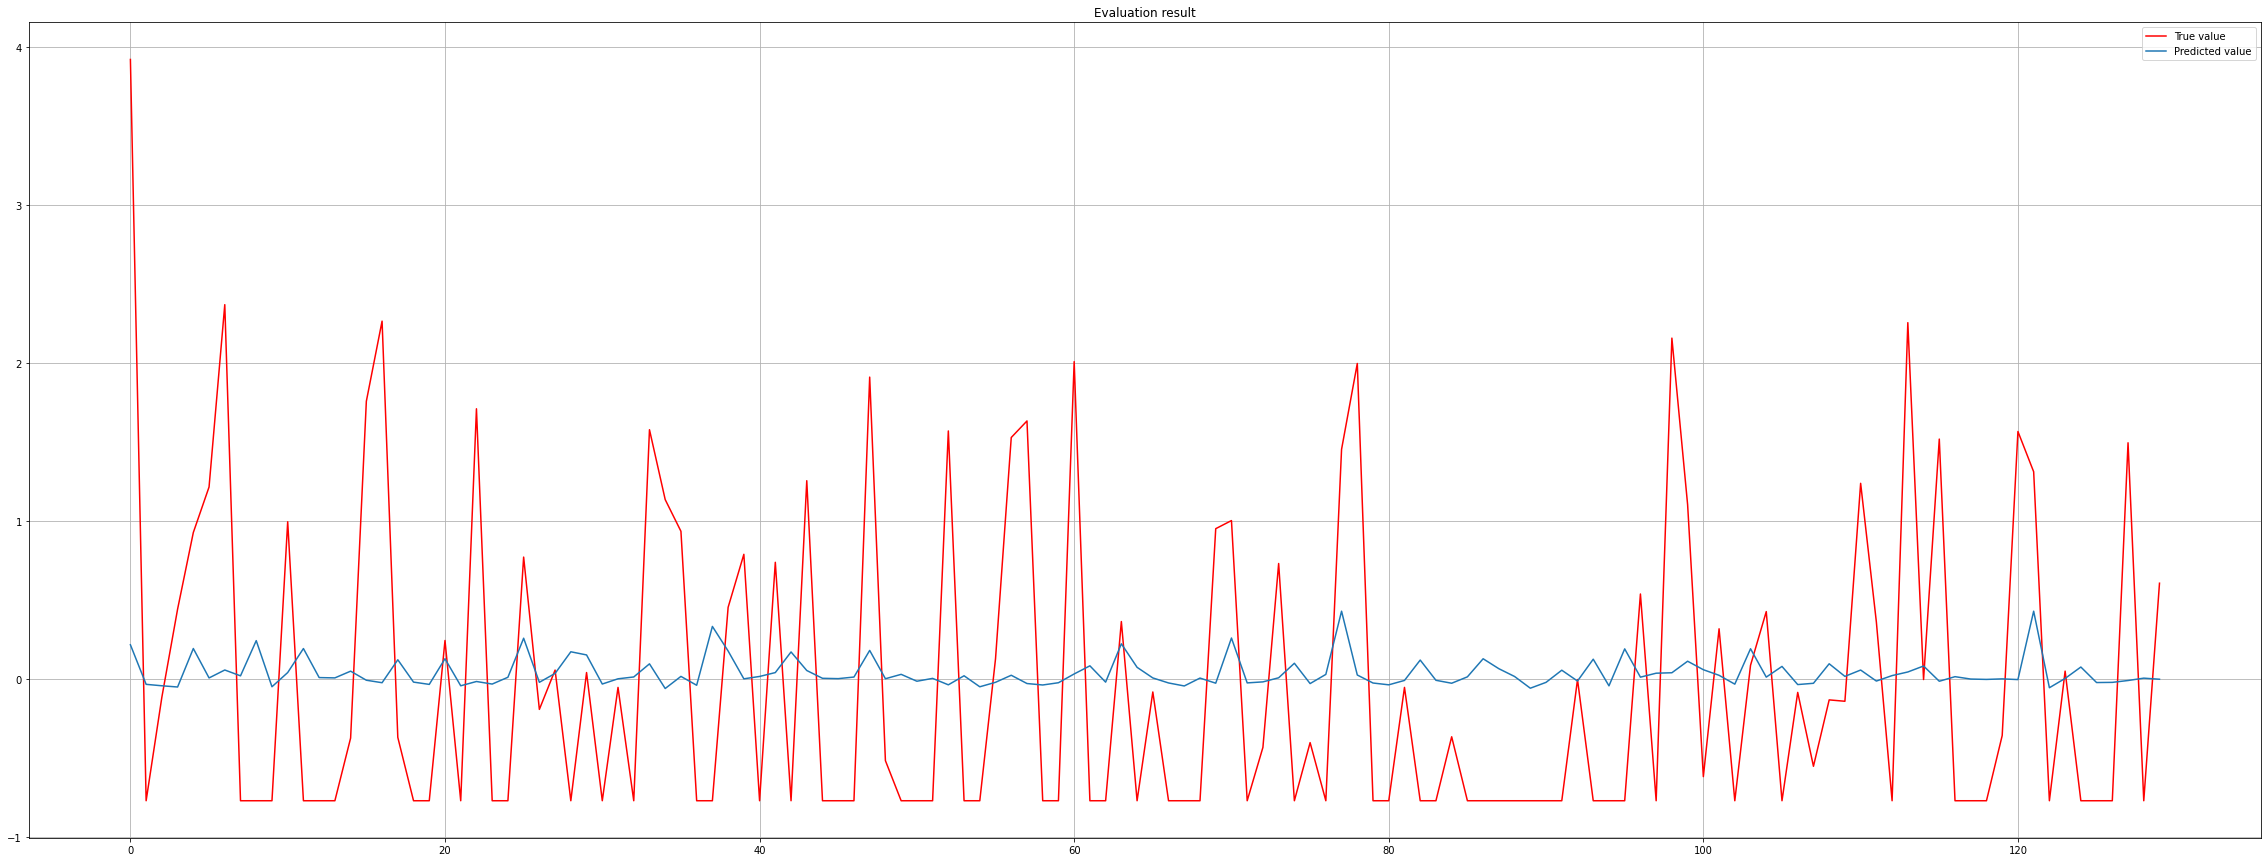

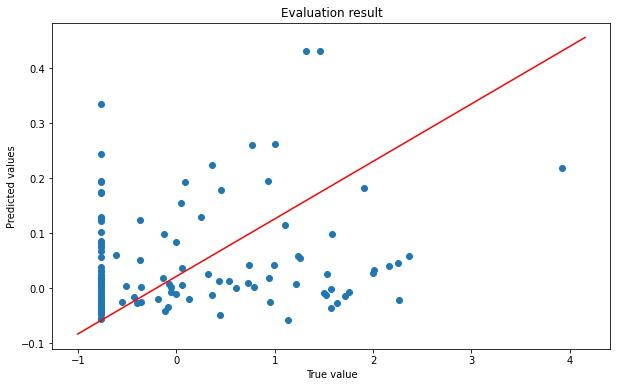

In [308]:
wrapp.plot_compare(prcp_target_test_predct)
wrapp.evaluation(prcp_target_test_predct)